In [1]:
from nanowire.optics.utils.config import Config
from nanowire.optics.simulate import Simulator
import numpy as np
import matplotlib as mpl
mpl.style.use('notebook')
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

# Utility Functions

In [21]:
def plot_kspace(L, Ng, show_actual=False):
    kspacemag = 2*np.pi/L
    kx = np.arange(-5*kspacemag, 5*kspacemag+kspacemag, kspacemag)
    ky = np.arange(-5*kspacemag, 5*kspacemag+kspacemag, kspacemag)
    kxx, kyy = np.meshgrid(kx, ky)
    kmax = np.sqrt(kxx**2 + kyy**2)
    rad = np.sqrt(4*np.pi*Ng/L**2)
    circ = Circle((0, 0), rad, fill=False)
    fig, ax = plt.subplots()
    ax.add_artist(circ)
    if show_actual:
        inner_rad = rad - 12
        circ = Circle((0, 0), inner_rad, fill=False, edgecolor='red')
        ax.add_artist(circ)
    ax.scatter(kxx.flatten(), kyy.flatten())
    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    plt.axis('equal')
    plt.show()

def setup_sim(conf):
    sim = Simulator(conf)
    sim.evaluate_config()
    sim.update_id()
    sim.make_logger()
    sim.configure()
    sim.build_device()
    sim.set_excitation()
    return sim

def get_arrays(sim, substrate_zvals, nw_zvals):
    result_dict = sim.get_fourier_coefficients(offset=0.)
    substrate_data = np.zeros((2, result_dict['Substrate'].shape[1], 
                               len(substrate_zvals)), dtype=np.complex128)
    substrate_data[:, :, 0] = result_dict['Substrate']
    for i, z in enumerate(substrate_zvals[1:]):
        layer_dict = sim.get_fourier_coefficients(offset=z)
        substrate_data[:, :, i+1] = layer_dict['Substrate']
    # I've discovered a somewhat weird and concerning bug here. When 
    # requesting the amplitudes at 0 offset in the NW layer, I get 
    # back 40 amplitudes (as if there were no proper truncation). The
    # first 26 amplitudes are reasonable numbers. The extra amplitudes
    # that we wouldn't expect to exist are numbers raised to the -310th
    # power (so zero). I don't know why these extra amplitudes are here.
    # This doesn't happen for any of the other z offsets, only at 0 
    # offset. The default offset is 0 according to the docs, meaning
    # GetAmplitudes(Layer=layer, zOffset=0) and GetAmplitudes(Layer=layer)
    # should return the same result. However, calling with explicitly a 
    # zero offset gives the incorrect shape, while leaving out the zOffset
    # arg gives the correct shape. SUPER WEIRD. For now I just have a 
    # check in my wrapper code to call GetAmplitudes without the zOffset 
    # arg if the offset is 0
    nw_data = np.zeros((2, result_dict['NW_AlShell'].shape[1], 
                        len(nw_zvals)), dtype=np.complex128)
    nw_data[:, :, 0] = result_dict['NW_AlShell']
    for i, z in enumerate(nw_zvals[1:]):
        layer_dict = sim.get_fourier_coefficients(offset=z)
        nw_data[:, :, i+1] = layer_dict['NW_AlShell']
    return substrate_data, nw_data

def plot_amplitudes(data):
    layer = data[:, :, 0]
    print(len(layer))
    print(len(layer[0,:]))
    print(len(layer[1,:]))
    forw_amps = np.array(layer[0, :])
    back_amps = np.array(layer[1, :])
    fabs_sq = np.absolute(forw_amps)**2
    babs_sq = np.absolute(back_amps)**2
    flog = np.where(fabs_sq < 1e-8, 0, fabs_sq)
    blog = np.where(babs_sq < 1e-8, 0, babs_sq)
    fig, axes = plt.subplots(2, 2, figsize=(9, 7))
    axes[0, 0].plot(fabs_sq)
    axes[0, 0].set_title('Forward Propagating Amplitudes')
    axes[1, 0].semilogy(flog)
    axes[1, 0].set_title('Forward Propagating Amplitudes')
    axes[0, 1].plot(babs_sq)
    axes[0, 1].set_title('Backward Propagating Amplitudes')
    axes[1, 1].semilogy(blog)
    axes[1, 1].set_title('Backward Propagating Amplitudes')
    plt.tight_layout()
    plt.show()

# $N_G$ = 20

First I just quickly load the base config file into an object that just automates a lot of annoying stuff. We can modify the `conf` object
in memory for the rest of the notebook. This is a typical NW device with Al shell. Params are in the config file for those who are interested.

In [3]:
conf = Config(path="optics.yml")

So I start off by specifying 20 basis terms, and look at the amplitudes in two different layers. First, I look at the substrate which is an
unpatterned layer. Then, I look at the nanowire layer which is a patterned layer. Note that here all the coefficients are taken at the
very top of the layer in question. The first row of plots is the absolute value squared of the complex amplitudes. The second row is the
same data plotted on a log scale.

## Layer = Substrate

2
26
26


/home/kyle_robertson/.virtualenvs/nanowire/lib/python3.5/site-packages/matplotlib/ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


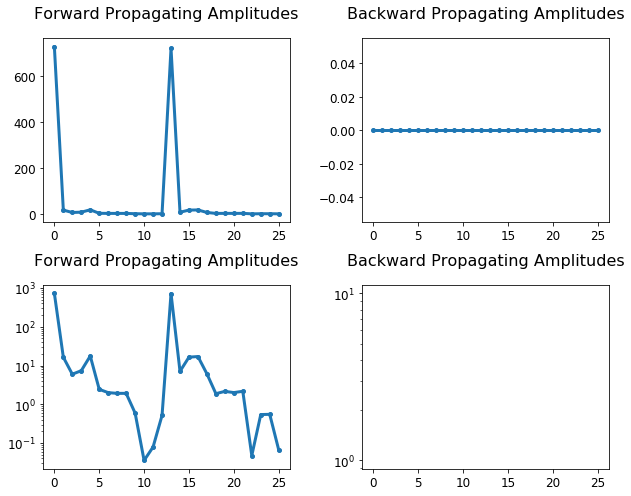

In [4]:
sim = setup_sim(conf)
substrate_t = sim.conf[('Layers', 'Substrate', 'params', 'thickness',
                        'value')]
nw_t = sim.conf[('Layers', 'NW_AlShell', 'params', 'thickness', 'value')]
substrate_zvals = np.linspace(0, substrate_t, 50)
nw_zvals = np.linspace(0, nw_t, 50)
substrate_data, nw_data = get_arrays(sim, substrate_zvals, nw_zvals)
plot_amplitudes(substrate_data)

Ok, what's going on here? Why do we get 26 amplitudes? I would like to (hopefully) clarify what these amplitudes correspond to 
physically and finally determine "how many basis terms" are actually being used when I run simulations. 
So, I'll start by establishing their notation. In real space imagine we have a square unit cell defined by the following
set of basis vectors:

\begin{align}
    L_r &= \left[ \vec{r_1} \vec{r_2}\right] \\
        &= 
    \begin{bmatrix}
            L & 0 \\
            0 & L
    \end{bmatrix}
\end{align}

where the vectors are contained in columns of the matrix above. We can get the reciprocal lattice unit vectors by 
 
\begin{align}
    L_k &= 2 \pi L_r^{-T} \\
         &= [ \vec{u}_1 \vec{u}_2 ]\\
        &= \frac{2 \pi}{L} 
    \begin{bmatrix}
            1 & 0 \\
            0 & 1
    \end{bmatrix}
\end{align}

The paper refers to $\vec{G}$ as a "reciprocal lattice vector". I take this to mean a linear combination of our
basis vectors in reciprocal space, so:

\begin{equation}
    \vec{G} = m \cdot \vec{u_1} + n \cdot \vec{u_2}
\end{equation}

where $m$ and $n$ are integers. The fields are then approximated as 

\begin{equation}
    \vec{E}(\vec{r}, z) = \sum_{\vec{G}} \vec{E}_G(z) e^{i (\vec{k} + \vec{G}) \cdot \vec{r}}
\end{equation}

where $\vec{r}$ is the in-plane vector in real space and $\vec{k}$ is the in-plane component of the wave 
vector of the incident light. For normally incident light we can set $\vec{k}$ to zero. Pulling from Eq. 24
of the S4 paper, these $\vec{E}_G(z)$ must look something like this:

\begin{equation}
	\vec{E}_G(z) = \left[ \phi_{G,x} \hat{x} + \phi_{G,y} \hat{y} - \frac{G_x \phi_{G,x} + G_y \phi_{G,y}}{q} \hat{z} \right]
    e^{iqz}
\end{equation}

where q ends up being the eigenvalue of an eigenvalue equation, and the $\phi$ are the components of the eigenvector.
The fact that there are 2 $\phi$ for every G explains why we get 26 amplitudes (explained in detail below). 

Now, for a "circular  truncation" we take all $\vec{G}$ within a circular region centered around the origin. The radius of this
region is determined by the parameter I provide as input to my simulations, what I've been referring to 
(somewhat imprecisely) as the number of basis terms (which I will call $N_G$ from now on). The circle must
contain $N_G$ points, which are located at some $\vec{G}$. This implicitly defines the radius in k space.
With a square unit cell of side length $L$, the areal ensity of "G-points" in k-space must be:

\begin{equation}
	\rho_k = \frac{L}{2 \pi}\frac{L}{2 \pi}
\end{equation}

We can multiply this by the area of the circle and set equal to $N_G$ to find the maximal k-vector
in either dimension we can reach

\begin{align}
	\frac{L^2}{4 \pi^2} \cdot \pi k_{\mathrm{max}}^2 &= N_G \\
    k_{\mathrm{max}} &= \sqrt{\frac{4 \pi N_G}{L^2}}
\end{align}

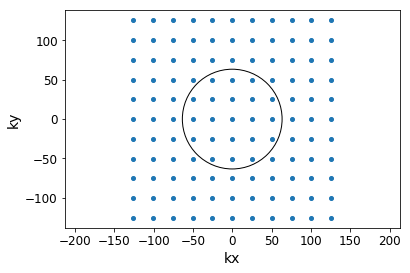

In [5]:
plot_kspace(.25, 20)

This radius is in theory the largest k-vector magnitude we could obtain. However, S4 chooses the circle 
automatically to "preserve symmetry considerations" while _also_ not exceeding the maximum number of
G-vectors specified by the user. By "preserve symmentry considerations", they mean if you have some
vector $\vec{G}$ in reciprocal space, you must also include $-\vec{G}$. If we include all the dots
shown in the circle above, we would hit 21 G-vectors. This is more than we asked for, so S4 shrinks
the circle like so:

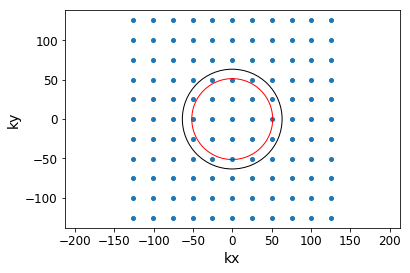

In [6]:
plot_kspace(.25, 20, show_actual=True)

The red circle now only contains 13 points, which is less than the maximum we requested, and the maximal distance we ever move
along either direction in k-space is $4 \pi/L$. Now we can see why we get 26 amplitudes. S4 has truncated to 13 lattice points
in k-space, and each lattice point has a mode with an x and y amplitude. This ends up giving $2 \cdot 13$ amplitudes. So the
"number of basis terms" ($N_G$) I specify is really "the maximum number of points in k-space to include", and this number can 
possibly be reduced depending on the unit vectors I define in real space and whether or not $N_G$ points will fit into a circle
symmetrically. 

However, this still does not explain which numbers in the list of amplitudes I get back correspond to which points in k-space.
There is a function in the Lua API called GetDiffractedOrder. It appears to take the indices (m, n) of the G vector as arguments,
and returns the 1-based index  you need to use to extract the power of that mode/diffraction order from the 1-D array returned by GetAmplitudes.
The documentation says this works for unpatterned layers, but definitively does not work for patterned layers and that, in the
case of a patterned layer, the GetDiffractedOrder function "returns the index of an arbitrary layer eigenmode". This GetDiffractedOrder
function is also not exposed in the Python API, so if I want to use it I have to write the underlying C code that glues Python and the
S4 C API together.

So with this information all in hand, here are the rest of the plots. I plot the z-dependence of the first amplitude of the forward propagating 
modes below. Then, I look at the nanowire layer and plot all the same stuff. Finally, I change $N_G$ and repeat.

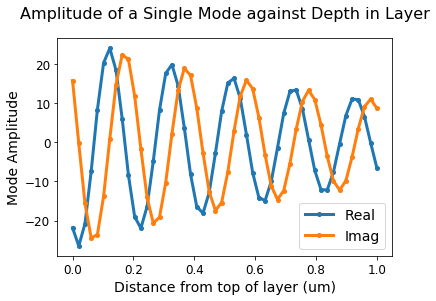

In [7]:
plt.figure()
plt.plot(substrate_zvals, substrate_data[0, 0, :].real, label='Real')
plt.plot(substrate_zvals, substrate_data[0, 0, :].imag, label='Imag')
plt.xlabel('Distance from top of layer (um)')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.title('Amplitude of a Single Mode against Depth in Layer')
plt.show()

So this is reassuring. We can see the $e^{iqz}$ dependence in the amplitude, as well as the physically expected attenuation with depth
into an absorbing layer. 

## Layer = Nanowire 

2
26
26


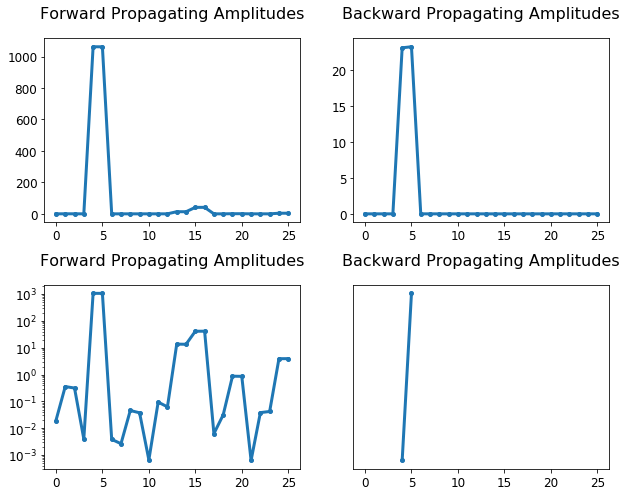

In [8]:
plot_amplitudes(nw_data)

So this is interesting, we can clearly see the nanowire has some highly resonant modes with larger amplitude than
all other modes. Checking out the z-dependence of some of these higher-amplitude modes below:

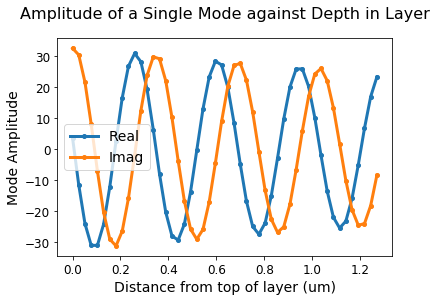

In [9]:
plt.figure()
plt.plot(nw_zvals, nw_data[0, 5, :].real, label='Real')
plt.plot(nw_zvals, nw_data[0, 5, :].imag, label='Imag')
plt.xlabel('Distance from top of layer (um)')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.title('Amplitude of a Single Mode against Depth in Layer')
plt.show()

# $N_G$ = 200

In [10]:
conf[('Simulation','params','numbasis','value')] = 200
sim = setup_sim(conf)
substrate_data, nw_data = get_arrays(sim, substrate_zvals, nw_zvals)

## Layer = Substrate

2
394
394


/home/kyle_robertson/.virtualenvs/nanowire/lib/python3.5/site-packages/matplotlib/ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


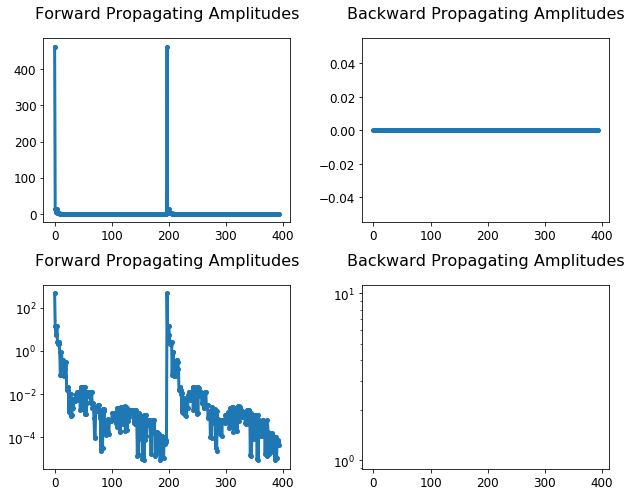

In [11]:
plot_amplitudes(substrate_data)

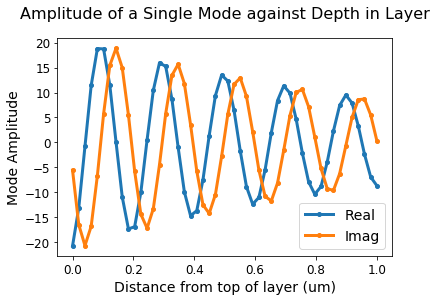

In [12]:
plt.figure()
plt.plot(substrate_zvals, substrate_data[0, 0, :].real, label='Real')
plt.plot(substrate_zvals, substrate_data[0, 0, :].imag, label='Imag')
plt.xlabel('Distance from top of layer (um)')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.title('Amplitude of a Single Mode against Depth in Layer')
plt.show()

## Layer = Nanowire

2
394
394


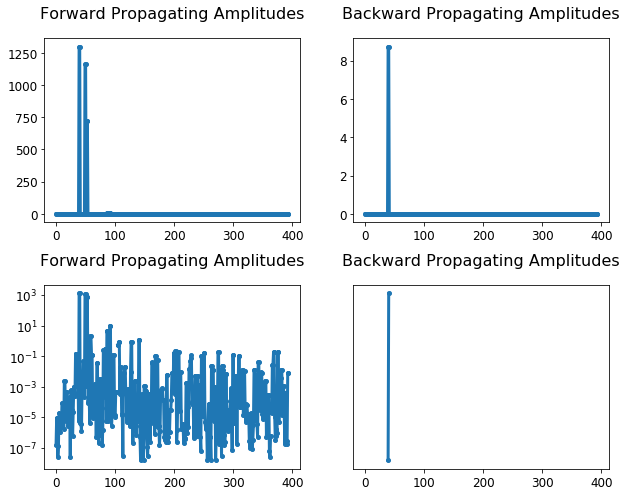

In [13]:
plot_amplitudes(nw_data)

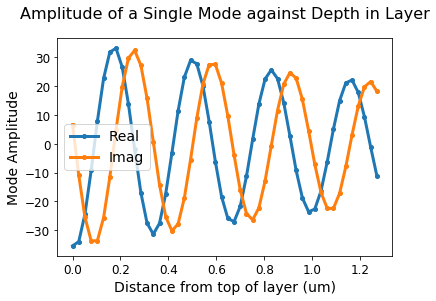

In [14]:
plt.figure()
plt.plot(nw_zvals, nw_data[0, 40, :].real, label='Real')
plt.plot(nw_zvals, nw_data[0, 40, :].imag, label='Imag')
plt.xlabel('Distance from top of layer (um)')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.title('Amplitude of a Single Mode against Depth in Layer')
plt.show()

# $N_G$ = 300

In [15]:
conf[('Simulation','params','numbasis','value')] = 300
sim = setup_sim(conf)
substrate_data, nw_data = get_arrays(sim, substrate_zvals, nw_zvals)

## Layer = Substrate

2
586
586


/home/kyle_robertson/.virtualenvs/nanowire/lib/python3.5/site-packages/matplotlib/ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


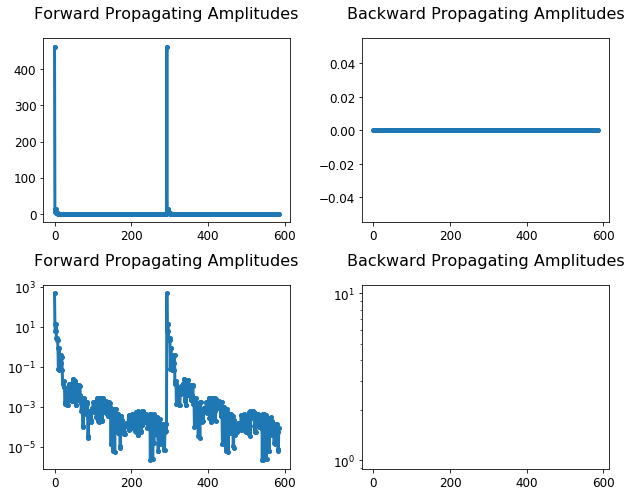

In [16]:
plot_amplitudes(substrate_data)

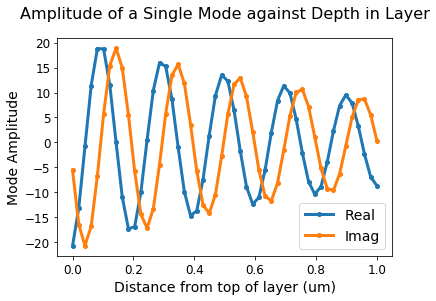

In [17]:
plt.figure()
plt.plot(substrate_zvals, substrate_data[0, 0, :].real, label='Real')
plt.plot(substrate_zvals, substrate_data[0, 0, :].imag, label='Imag')
plt.xlabel('Distance from top of layer (um)')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.title('Amplitude of a Single Mode against Depth in Layer')
plt.show()

## Layer = Nanowire

2
586
586


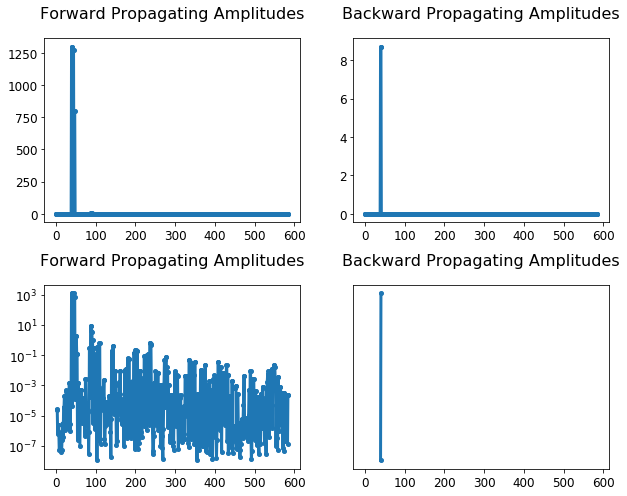

In [18]:
plot_amplitudes(nw_data)

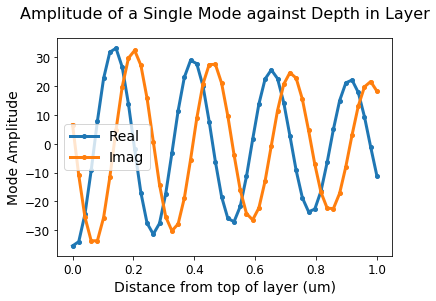

In [20]:
plt.figure()
plt.plot(substrate_zvals, nw_data[0, 40, :].real, label='Real')
plt.plot(substrate_zvals, nw_data[0, 40, :].imag, label='Imag')
plt.xlabel('Distance from top of layer (um)')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.title('Amplitude of a Single Mode against Depth in Layer')
plt.show()